In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
file_path = "/workspaces/ADS-504-02-Group-7-Machine-Learning-and-Deep-Learning-for-Data-Science/nvda_2018.csv"

In [3]:
data = pd.read_csv(file_path)

# Correct column names as per the screenshot
correct_column_names = [
    "time",
    "open",
    "high",
    "low",
    "close",
    "PlotCandle (Open)",
    "PlotCandle (High)",
    "PlotCandle (Low)",
    "PlotCandle (Close)",
    "VWAP",
    "Upper Band #1",
    "Lower Band #1",
    "Upper Band #2",
    "Lower Band #2",
    "Upper Band #3",
    "Lower Band #3",
    "MidLine",
    "ImpulseMACD",
    "ImpulseHisto",
    "ImpulseMACDSignal",
    "RSI",
    "Regular Bullish Label",
    "Regular Bullish",
    "Hidden Bullish Label",
    "Hidden Bullish",
    "Regular Bearish Label",
    "Regular Bearish",
    "Hidden Bearish Label",
    "Hidden Bearish",
]
data.columns = correct_column_names

In [4]:
# Drop columns with less or no data after EDA
columns_to_remove = [
    "Hidden Bullish",
    "Hidden Bullish Label",
    "Hidden Bearish",
    "Hidden Bearish Label",
]
data = data.drop(columns=columns_to_remove)

# Handle outliers by clipping to 1.5*IQR
for column in data.select_dtypes(include=[np.number]).columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = np.clip(data[column], lower_bound, upper_bound)

In [5]:
# Feature engineering: add day of the week and morning vs. afternoon
data["time"] = pd.to_datetime(data["time"], unit="s")
data["day_of_week"] = data["time"].dt.dayofweek
data["morning_afternoon"] = np.where(data["time"].dt.hour < 12, "morning", "afternoon")

In [6]:
# Convert categorical features to numerical
data = pd.get_dummies(
    data, columns=["day_of_week", "morning_afternoon"], drop_first=True
)

In [7]:
# Check for initial missing values
print("Initial missing values:")
print(data.isnull().sum())

Initial missing values:
time                         0
open                         0
high                         0
low                          0
close                        0
PlotCandle (Open)            0
PlotCandle (High)            0
PlotCandle (Low)             0
PlotCandle (Close)           0
VWAP                         0
Upper Band #1                0
Lower Band #1                0
Upper Band #2                0
Lower Band #2                0
Upper Band #3                0
Lower Band #3                0
MidLine                      0
ImpulseMACD                  0
ImpulseHisto                 0
ImpulseMACDSignal            0
RSI                          0
Regular Bullish Label    10978
Regular Bullish          11704
Regular Bearish Label    10969
Regular Bearish          11642
day_of_week_1                0
day_of_week_2                0
day_of_week_3                0
day_of_week_4                0
dtype: int64


In [8]:
# Handle initial missing values if any
data.fillna(method="ffill", inplace=True)

# Create the target variable: close - open
data["target"] = data["close"] - data["open"]

/tmp/ipykernel_13195/1483503138.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [10]:
# Predict the next period's close minus open
data["target_t+1"] = data["target"].shift(-1)

# Handle NaN introduced by the shift
data.dropna(subset=["target_t+1"], inplace=True)

# Extract features and target variable
X = data.drop(columns=["time", "close", "target", "target_t+1"])
y = data["target_t+1"]

In [11]:
# Verify the size of X and y before splitting
print(f"Size of X: {X.shape}")
print(f"Size of y: {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Size of X: (11750, 27)
Size of y: (11750,)


In [13]:
from sklearn.preprocessing import RobustScaler

# Scale the features
scaler = RobustScaler()  # Using RobustScaler as an alternative to StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

# Assuming X_train_scaled and y_train are already defined and populated with data

# Check if the dataset is empty
if X_train_scaled.shape[0] == 0 or y_train.shape[0] == 0:
    raise ValueError(
        "The training dataset is empty. Please provide a non-empty dataset."
    )

# Handle missing values
imputer = SimpleImputer(strategy="mean")
X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)

# Cross-validation
cv_scores_lr = cross_val_score(
    lr_model, X_train_scaled_imputed, y_train, cv=10, scoring="r2"
)
cv_scores_rf = cross_val_score(
    rf_model, X_train_scaled_imputed, y_train, cv=10, scoring="r2"
)

print(f"Linear Regression 10-fold CV R2: {np.mean(cv_scores_lr)}")
print(f"Random Forest 10-fold CV R2: {np.mean(cv_scores_rf)}")

Linear Regression 10-fold CV R2: -0.006530819449591529
Random Forest 10-fold CV R2: -0.0832517533496278


In [20]:
# Create an imputer transformer
imputer = SimpleImputer(strategy="mean")

# Fit the imputer on the training data and transform both training and testing data
X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)
X_test_scaled_imputed = imputer.transform(X_test_scaled)

# Train models
lr_model.fit(X_train_scaled_imputed, y_train)
rf_model.fit(X_train_scaled_imputed, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test_scaled_imputed)
rf_predictions = rf_model.predict(X_test_scaled_imputed)
rf_predictions = rf_model.predict(X_test_scaled)

In [21]:
# Evaluate models
lr_mse = mean_squared_error(y_test, lr_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
lr_r2 = r2_score(y_test, lr_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print(f"Linear Regression MSE: {lr_mse}, R2: {lr_r2}")
print(f"Random Forest MSE: {rf_mse}, R2: {rf_r2}")

Linear Regression MSE: 0.0358973957630885, R2: -0.008305527955867031
Random Forest MSE: 0.03631606467261289, R2: -0.020065327431091573


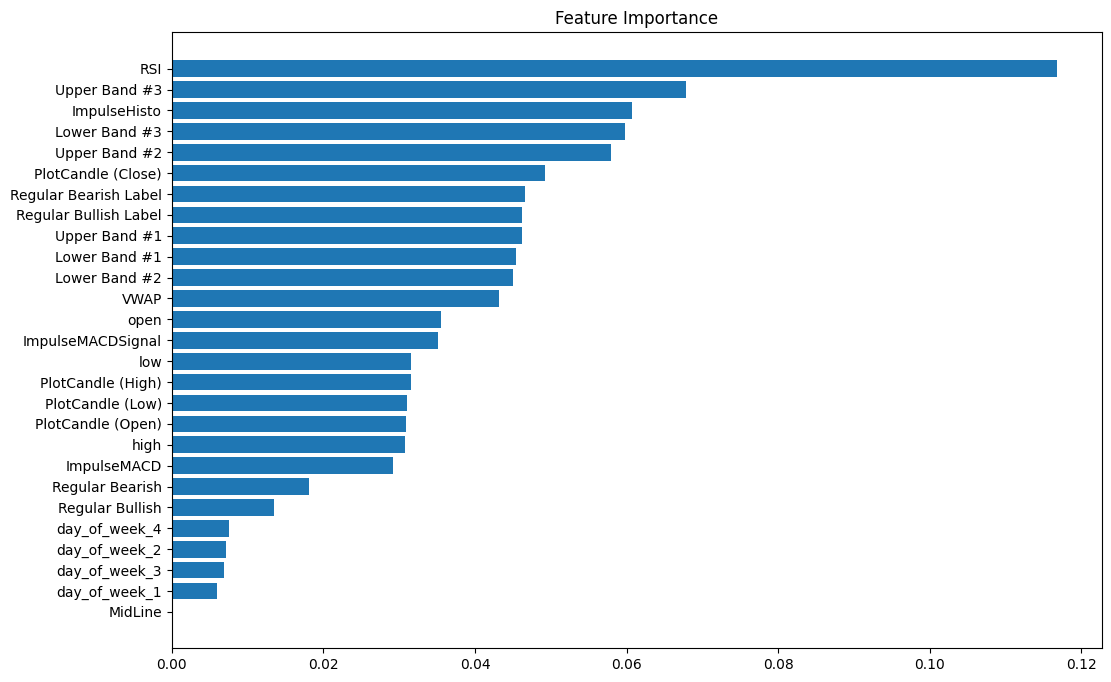

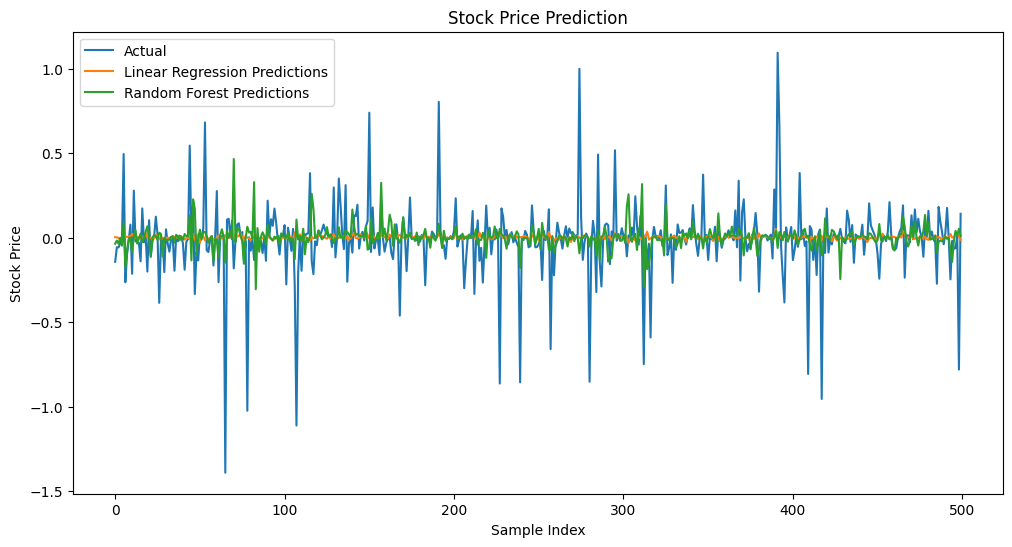

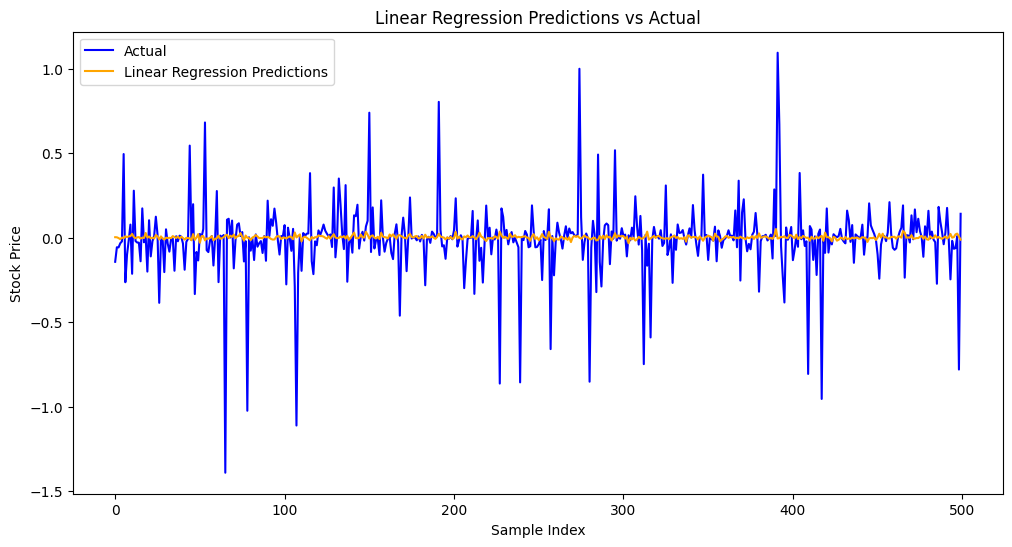

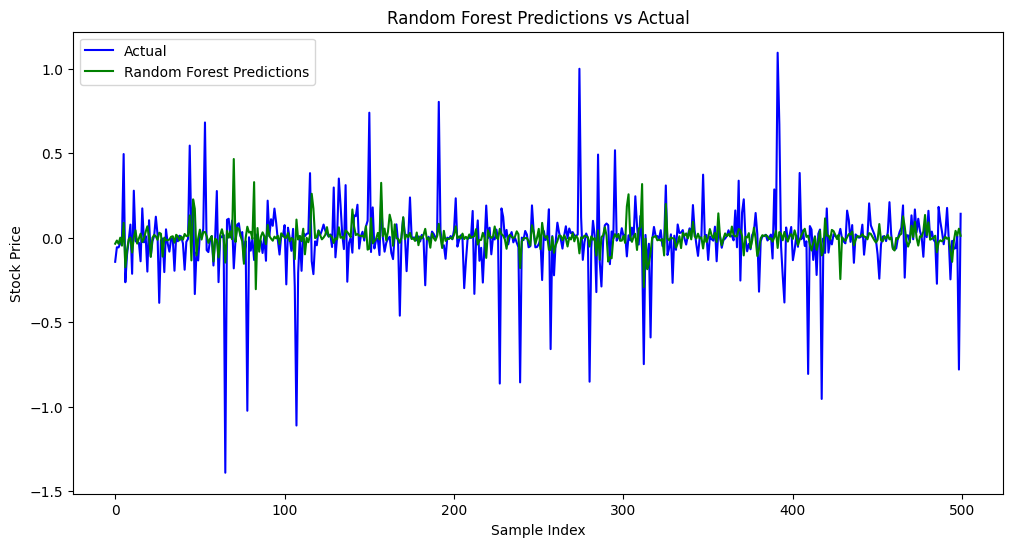

In [22]:
# Feature importance
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
plt.title("Feature Importance")
plt.show()

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(
    y_test.values[:500], label="Actual"
)  # Limiting to first 500 samples for better visualization
plt.plot(lr_predictions[:500], label="Linear Regression Predictions")
plt.plot(rf_predictions[:500], label="Random Forest Predictions")
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Sample Index")
plt.ylabel("Stock Price")
plt.show()

# Separate plots for clearer comparison
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:500], label="Actual", color="blue")
plt.plot(lr_predictions[:500], label="Linear Regression Predictions", color="orange")
plt.legend()
plt.title("Linear Regression Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Stock Price")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:500], label="Actual", color="blue")
plt.plot(rf_predictions[:500], label="Random Forest Predictions", color="green")
plt.legend()
plt.title("Random Forest Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Stock Price")
plt.show()